# TSA ARMA

Testing some more time series analysis methods...

In [9]:
# import section
import os
import numpy as np
import pandas as pd
import xarray as xr
import statsmodels.tsa as tsa
import statsmodels.tsa.arima.model

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read some dataset...
data_dir = '/Users/oberrauch/work/master/data/'
f_path = 'cluster_output/showcase_glaciers_random_climate/eq_runs.nc'
ds = xr.load_dataset(os.path.join(data_dir, f_path))
ds['normalized'] = ds.normalized.astype(bool) 

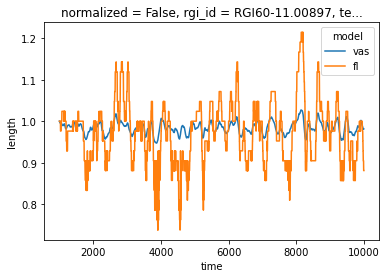

In [3]:
# select any arbitrary length record
rgi_id = 'RGI60-11.00897'
temp_bias=0.5
ds_tmp = ds.sel(rgi_id=rgi_id, 
                temp_bias=temp_bias, normalized=False, 
                time=slice(1e3,None)).length.squeeze()
# plot normalized length of both models
(ds_tmp/ds_tmp.isel(time=0)).plot.line(x='time')

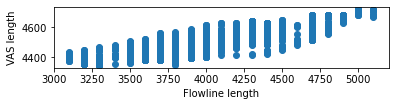

In [4]:
# plot scatter
plt.scatter(ds_tmp.sel(model='fl'), ds_tmp.sel(model='vas'),)
plt.xlabel('Flowline length')
plt.ylabel('VAS length')
plt.gca().set_aspect('equal')

In [5]:
# compute correlation coefficient
cc = xr.corr(ds_tmp.sel(model='fl'), ds_tmp.sel(model='vas')).values
print(f'R squared for length vas/fl: {cc:.2f}')

R squared for length vas/fl: 0.83


In [65]:
# select any arbitrary length record
model = 'fl'
rgi_id = 'RGI60-11.00897'
temp_bias=0.5
length = ds.sel(model=model, rgi_id=rgi_id, 
                temp_bias=temp_bias, normalized=False, 
                time=slice(1e3,None))[['time', 'length']].squeeze()
length

<xarray.Dataset>
Dimensions:         (time: 9001)
Coordinates:
  * time            (time) float64 1e+03 1.001e+03 1.002e+03 ... 9.999e+03 1e+04
    hydro_year      (time) int64 1000 1001 1002 1003 ... 9997 9998 9999 10000
    calendar_year   (time) int64 999 1000 1001 1002 1003 ... 9996 9997 9998 9999
    hydro_month     (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    calendar_month  (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10 10
    normalized      bool False
    rgi_id          <U14 'RGI60-11.00897'
    model           <U2 'fl'
    temp_bias       float64 0.5
    mb_model        <U6 'random'
Data variables:
    length          (time) float64 4.2e+03 4.2e+03 4.2e+03 ... 3.7e+03 3.7e+03
Attributes:
    description:    OGGM model output
    oggm_version:   1.3.2.dev86+g5d61f9d
    calendar:       365-day no leap
    creation_date:  2020-08-25 10:42:23

In [64]:
length['length']

time
1000.0     4200.0
1001.0     4200.0
1002.0     4200.0
1003.0     4200.0
1004.0     4200.0
            ...  
9996.0     3700.0
9997.0     3700.0
9998.0     3700.0
9999.0     3700.0
10000.0    3700.0
Name: length, Length: 9001, dtype: float64

In [ ]:
# check for stationarity
plt.plot()

In [15]:
# trow it into statsmodel.ARMA and see what happens
arma = tsa.arima.model.ARIMA(length, order=(10,0,10))
res = arma.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 9001
Model:               ARIMA(10, 0, 10)   Log Likelihood              -45932.241
Date:                Wed, 14 Oct 2020   AIC                          91908.482
Time:                        17:48:09   BIC                          92064.794
Sample:                             0   HQIC                         91961.670
                               - 9001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4080.0132   8910.667      0.458      0.647   -1.34e+04    2.15e+04
ar.L1         -0.4167      0.164     -2.542      0.011      -0.738      -0.095
ar.L2         -1.0042      0.222     -4.525      0.0

In [22]:
# select any arbitrary length record
model = 'vas'
rgi_id = 'RGI60-11.00897'
temp_bias=0.5
length = ds.sel(model=model, rgi_id=rgi_id, 
                temp_bias=temp_bias, normalized=False, 
                time=slice(1e3,None)).length.squeeze().values 

In [24]:
# trow it into statsmodel.ARMA and see what happens
arma = tsa.arima.model.ARIMA(length, order=(3,0,3))
model_fit = arma.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 9001
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1583.954
Date:                Thu, 15 Oct 2020   AIC                           3183.907
Time:                        09:03:37   BIC                           3240.748
Sample:                             0   HQIC                          3203.248
                               - 9001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4518.5163      6.624    682.102      0.000    4505.533    4531.500
ar.L1          2.2841      0.859      2.658      0.008       0.600       3.968
ar.L2         -1.5841      1.700     -0.932      0.3

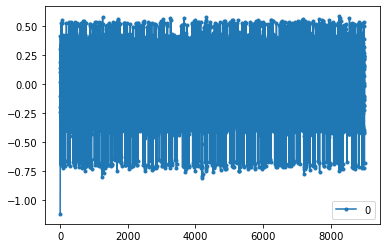

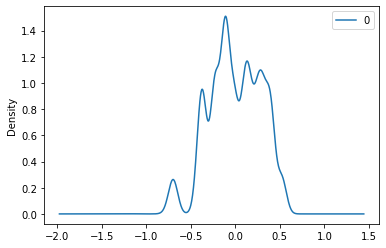

                 0
count  9000.000000
mean     -0.000212
std       0.288547
min      -1.120729
25%      -0.215230
50%      -0.012005
75%       0.240126
max       0.588022


In [37]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)[1:]
residuals.plot(marker='.')
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [38]:
model_fit.forecast()

array([4506.4334012])

In [48]:
X = length
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(30):
    model = tsa.arima.model.ARIMA(history, order=(3,0,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))


predicted=4554.161310, expected=4554.472490
predicted=4555.320877, expected=4554.978981
predicted=4555.451483, expected=4555.451305
predicted=4555.884301, expected=4555.711180
predicted=4555.940473, expected=4555.718837
predicted=4555.700599, expected=4555.458149
predicted=4555.177857, expected=4555.171705
predicted=4554.863841, expected=4554.774323
predicted=4554.361442, expected=4553.986058
predicted=4553.194557, expected=4553.177883
predicted=4552.361785, expected=4551.952249
predicted=4550.734110, expected=4550.594368
predicted=4549.242644, expected=4549.559311
predicted=4548.520840, expected=4548.409802
predicted=4547.269585, expected=4546.542628
predicted=4544.708208, expected=4544.678772
predicted=4542.835753, expected=4542.935546
predicted=4541.212585, expected=4541.531865
predicted=4540.143671, expected=4539.432010
predicted=4537.379500, expected=4537.085211
predicted=4534.781547, expected=4534.952025
predicted=4532.852350, expected=4532.487641
predicted=4530.073939, expected=

ValueError: Found input variables with inconsistent numbers of samples: [3061, 30]

Test MSE: 0.094


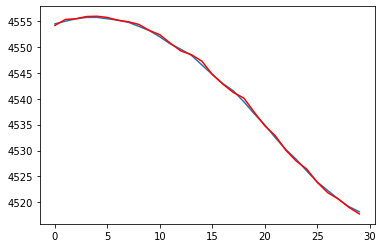

In [51]:
error = mean_squared_error(test[:30], predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test[:30])
plt.plot(predictions, color='red')
plt.show()

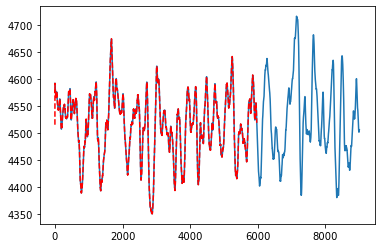

In [57]:
plt.plot(length)
plt.plot(model_fit.fittedvalues, 'r--')

In [47]:
from sklearn.metrics import mean_squared_error

In [ ]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
series = pd.Series(length)

size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
